# My Content - Exploration Approfondie des Données

## Objectif
Explorer en profondeur les données du système de recommandation My Content pour:
- Comprendre la structure et les patterns dans les données
- Créer des labels interprétables pour les catégories et articles
- Analyser les comportements utilisateurs
- Identifier les insights clés pour améliorer le système de recommandation

## Structure du notebook
1. **Configuration et imports**
2. **Nettoyage et préparation des données**
3. **Chargement intelligent des données**
4. **Exploration des métadonnées d'articles**
5. **Analyse temporelle approfondie**
6. **Création de labels pour les catégories**
7. **Analyse des comportements utilisateurs**
8. **Exploration des embeddings**
9. **Insights et recommandations**

## 1. Configuration et imports

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import glob
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Imports pour l'analyse avancée
from scipy import stats
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Imports pour le traitement de texte et clustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from collections import defaultdict, Counter

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

# Configuration Plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

## 2. Chargement intelligent des données

In [2]:
# NETTOYAGE DES DONNÉES
print("NETTOYAGE ET VALIDATION DES DONNÉES")
print("="*60)

# Charger les données brutes
articles_df_raw = pd.read_csv('data/articles_metadata.csv')
print(f"Articles chargés (avant nettoyage): {len(articles_df_raw):,}")

# 1. ANALYSE DES PROBLÈMES
zero_words = articles_df_raw[articles_df_raw['words_count'] == 0]
very_short = articles_df_raw[articles_df_raw['words_count'] < 10]
very_long = articles_df_raw[articles_df_raw['words_count'] > 1500]

# 2. STRATÉGIE DE NETTOYAGE
# Copier pour le nettoyage
articles_df = articles_df_raw.copy()

# A. Traiter les articles avec 0 mots
median_by_category = articles_df.groupby('category_id')['words_count'].median()
for idx in articles_df[articles_df['words_count'] == 0].index:
    cat_id = articles_df.loc[idx, 'category_id']
    if cat_id in median_by_category.index:
        articles_df.loc[idx, 'words_count'] = median_by_category[cat_id]
    else:
        articles_df.loc[idx, 'words_count'] = articles_df['words_count'].median()

# B. Filtrer les valeurs extrêmes
initial_count = len(articles_df)
articles_df = articles_df[(articles_df['words_count'] >= 10) & (articles_df['words_count'] <= 2000)]

# C. Supprimer les doublons
articles_df = articles_df.drop_duplicates(subset=['article_id'])

# D. Validation des timestamps
articles_df['created_at'] = pd.to_datetime(articles_df['created_at_ts'], unit='ms')
date_min = pd.Timestamp('2010-01-01')
date_max = pd.Timestamp.now()
valid_dates = (articles_df['created_at'] >= date_min) & (articles_df['created_at'] <= date_max)
articles_df = articles_df[valid_dates]

# E. Enrichissement des données
articles_df['year'] = articles_df['created_at'].dt.year
articles_df['month'] = articles_df['created_at'].dt.month
articles_df['day_of_week'] = articles_df['created_at'].dt.day_name()
articles_df['hour'] = articles_df['created_at'].dt.hour

articles_df['word_count_category'] = pd.cut(
    articles_df['words_count'],
    bins=[0, 100, 200, 300, 500, 2000],
    labels=['very_short', 'short', 'medium', 'long', 'very_long']
)

print(f"Articles après nettoyage: {len(articles_df):,}")
print(f"Taux de rétention: {len(articles_df)/len(articles_df_raw)*100:.1f}%")

NETTOYAGE ET VALIDATION DES DONNÉES
Articles chargés (avant nettoyage): 364,047
Articles après nettoyage: 363,919
Taux de rétention: 100.0%


## 2. Nettoyage et préparation des données

Cette section assure la qualité des données avant l'analyse approfondie.

In [3]:
# Chargement des embeddings
with open('data/articles_embeddings.pickle', 'rb') as f:
    articles_embeddings = pickle.load(f)

# Analyse des embeddings
embeddings_array = np.array(articles_embeddings)
embeddings_stats = {
    "Nombre d'embeddings": len(articles_embeddings),
    "Dimension des embeddings": embeddings_array.shape[1],
    "Valeur moyenne": embeddings_array.mean(),
    "Écart-type": embeddings_array.std(),
    "Valeur min": embeddings_array.min(),
    "Valeur max": embeddings_array.max(),
    "Nombre de valeurs nulles": (embeddings_array == 0).sum(),
    "Taille en mémoire (MB)": embeddings_array.nbytes / 1024**2
}

print(f"Embeddings chargés: {embeddings_array.shape}")
print(f"Dimension: {embeddings_array.shape[1]}")

Embeddings chargés: (364047, 250)
Dimension: 250


In [4]:
# Chargement des métadonnées des articles
articles_df = pd.read_csv('data/articles_metadata.csv')

# Conversion des timestamps en datetime pour une meilleure interprétabilité
articles_df['created_at'] = pd.to_datetime(articles_df['created_at_ts'], unit='ms')
articles_df['year'] = articles_df['created_at'].dt.year
articles_df['month'] = articles_df['created_at'].dt.month
articles_df['day_of_week'] = articles_df['created_at'].dt.day_name()
articles_df['hour'] = articles_df['created_at'].dt.hour

# Statistiques temporelles stockées dans un dictionnaire
stats_temporelles = {
    "Date du premier article": articles_df['created_at'].min().strftime('%Y-%m-%d'),
    "Date du dernier article": articles_df['created_at'].max().strftime('%Y-%m-%d'),
    "Période couverte (années)": (articles_df['created_at'].max() - articles_df['created_at'].min()).days / 365.25,
    "Nombre d'années uniques": articles_df['year'].nunique(),
    "Année avec le plus d'articles": articles_df['year'].value_counts().index[0]
}

# Aperçu des données
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count,created_at,year,month,day_of_week,hour
0,0,0,1513144419000,0,168,2017-12-13 05:53:39,2017,12,Wednesday,5
1,1,1,1405341936000,0,189,2014-07-14 12:45:36,2014,7,Monday,12
2,2,1,1408667706000,0,250,2014-08-22 00:35:06,2014,8,Friday,0
3,3,1,1408468313000,0,230,2014-08-19 17:11:53,2014,8,Tuesday,17
4,4,1,1407071171000,0,162,2014-08-03 13:06:11,2014,8,Sunday,13


In [5]:
# Chargement progressif de tous les fichiers de clics
click_files = sorted(glob.glob('data/clicks/clicks_hour_*.csv'))

def load_clicks_intelligently(files, sample_size=50):
    """Charge les fichiers de clics de manière intelligente avec nettoyage"""
    all_clicks = []
    total_rows = 0
    file_stats = []
    
    for i, file in enumerate(files[:sample_size]):
        df_temp = pd.read_csv(file)
        all_clicks.append(df_temp)
        total_rows += len(df_temp)
        
        file_stats.append({
            'file_index': i,
            'rows': len(df_temp),
            'users': df_temp['user_id'].nunique(),
            'articles': df_temp['click_article_id'].nunique()
        })
    
    clicks_df = pd.concat(all_clicks, ignore_index=True)
    return clicks_df, pd.DataFrame(file_stats)

# Charger les données
clicks_df_raw, file_stats_df = load_clicks_intelligently(click_files, sample_size=50)

# NETTOYAGE DES DONNÉES DE CLICS
clicks_df = clicks_df_raw.copy()

# 1. Supprimer les doublons
clicks_df = clicks_df.drop_duplicates()

# 2. Filtrer les sessions anormales
clicks_df = clicks_df[clicks_df['session_size'] <= 200]

# 3. Valider que les articles cliqués existent dans les métadonnées
valid_articles = set(articles_df['article_id'].unique())
clicks_df = clicks_df[clicks_df['click_article_id'].isin(valid_articles)]

# 4. Enrichir les données de clics
clicks_df['session_start_dt'] = pd.to_datetime(clicks_df['session_start'], unit='ms')
clicks_df['click_timestamp_dt'] = pd.to_datetime(clicks_df['click_timestamp'], unit='ms')
clicks_df['hour_of_day'] = clicks_df['click_timestamp_dt'].dt.hour
clicks_df['day_of_week'] = clicks_df['click_timestamp_dt'].dt.day_name()

# 5. Calculer des métriques dérivées
clicks_df['time_to_click'] = (clicks_df['click_timestamp'] - clicks_df['session_start']) / 1000

# Filtrer les temps de clic anormaux
clicks_df = clicks_df[(clicks_df['time_to_click'] >= 0) & (clicks_df['time_to_click'] <= 3600)]

print(f"Clics après nettoyage: {len(clicks_df):,}")
print(f"Taux de rétention: {len(clicks_df)/len(clicks_df_raw)*100:.1f}%")

# Statistiques sur les fichiers
file_loading_stats = {
    "Moyenne de lignes par fichier": file_stats_df['rows'].mean(),
    "Min lignes": file_stats_df['rows'].min(),
    "Max lignes": file_stats_df['rows'].max(),
    "Écart-type": file_stats_df['rows'].std()
}

Clics après nettoyage: 412,634
Taux de rétention: 92.0%


In [6]:
# Chargement des données de clics - échantillon
clicks_sample = pd.read_csv('data/clicks_sample.csv')

# Conversion des timestamps
clicks_sample['session_start_dt'] = pd.to_datetime(clicks_sample['session_start'], unit='ms')
clicks_sample['click_timestamp_dt'] = pd.to_datetime(clicks_sample['click_timestamp'], unit='ms')

# Calcul de métriques dérivées
clicks_sample['time_to_click'] = (clicks_sample['click_timestamp'] - clicks_sample['session_start']) / 1000  # en secondes
clicks_sample['hour_of_day'] = clicks_sample['click_timestamp_dt'].dt.hour
clicks_sample['day_of_week'] = clicks_sample['click_timestamp_dt'].dt.day_name()

# Statistiques des sessions stockées dans un dictionnaire
session_stats = {
    "Utilisateurs uniques": clicks_sample['user_id'].nunique(),
    "Sessions uniques": clicks_sample['session_id'].nunique(),
    "Articles uniques cliqués": clicks_sample['click_article_id'].nunique(),
    "Taille moyenne de session": clicks_sample['session_size'].mean(),
    "Temps moyen avant clic (sec)": clicks_sample['time_to_click'].mean(),
    "Environnements uniques": clicks_sample['click_environment'].nunique(),
    "Pays uniques": clicks_sample['click_country'].nunique(),
    "Régions uniques": clicks_sample['click_region'].nunique()
}

In [7]:
# Chargement progressif de tous les fichiers de clics
click_files = sorted(glob.glob('data/clicks/clicks_hour_*.csv'))

# Stratégie de chargement adaptative
def load_clicks_intelligently(files, sample_size=50):
    """Charge les fichiers de clics de manière intelligente"""
    all_clicks = []
    total_rows = 0
    file_stats = []
    
    for i, file in enumerate(files[:sample_size]):
        df_temp = pd.read_csv(file)
        all_clicks.append(df_temp)
        total_rows += len(df_temp)
        
        # Collecter des statistiques sur chaque fichier
        file_stats.append({
            'file_index': i,
            'rows': len(df_temp),
            'users': df_temp['user_id'].nunique(),
            'articles': df_temp['click_article_id'].nunique()
        })
    
    # Concatener tous les DataFrames
    clicks_df = pd.concat(all_clicks, ignore_index=True)
    
    return clicks_df, pd.DataFrame(file_stats)

# Charger les données
clicks_df, file_stats_df = load_clicks_intelligently(click_files, sample_size=50)

# Enrichir les données de clics
clicks_df['session_start_dt'] = pd.to_datetime(clicks_df['session_start'], unit='ms')
clicks_df['click_timestamp_dt'] = pd.to_datetime(clicks_df['click_timestamp'], unit='ms')
clicks_df['hour_of_day'] = clicks_df['click_timestamp_dt'].dt.hour
clicks_df['day_of_week'] = clicks_df['click_timestamp_dt'].dt.day_name()

# Statistiques sur les fichiers stockées
file_loading_stats = {
    "Moyenne de lignes par fichier": file_stats_df['rows'].mean(),
    "Min lignes": file_stats_df['rows'].min(),
    "Max lignes": file_stats_df['rows'].max(),
    "Écart-type": file_stats_df['rows'].std()
}

## 2.1 Analyse des données manquantes

Examen détaillé des valeurs manquantes dans nos datasets pour identifier les patterns et définir des stratégies de traitement appropriées.

In [8]:
# Analyse des données manquantes - Articles
print("ANALYSE DES DONNÉES MANQUANTES - ARTICLES")

# Charger les données brutes pour l'analyse
articles_raw = pd.read_csv('data/articles_metadata.csv')

# Fonction pour analyser les valeurs manquantes
def analyze_missing_data(df, df_name):
    """Analyse détaillée des valeurs manquantes dans un DataFrame"""
    
    missing_info = pd.DataFrame({
        'Colonne': df.columns,
        'Type': df.dtypes.values,
        'Valeurs_Manquantes': df.isnull().sum().values,
        'Pourcentage_Manquant': (df.isnull().sum().values / len(df) * 100).round(2),
        'Valeurs_Uniques': [df[col].nunique() for col in df.columns],
        'Valeurs_Zero': [(df[col] == 0).sum() if df[col].dtype in ['int64', 'float64'] else 0 for col in df.columns]
    })
    
    missing_info['Valeurs_Vides'] = [
        (df[col] == '').sum() if df[col].dtype == 'object' else 0 
        for col in df.columns
    ]
    
    # Trier par pourcentage de valeurs manquantes
    missing_info = missing_info.sort_values('Pourcentage_Manquant', ascending=False)
    
    return missing_info

# Analyser les articles
articles_missing = analyze_missing_data(articles_raw, 'Articles')

print("\nRésumé des valeurs manquantes - Articles:")
print(f"  Nombre total de lignes: {len(articles_raw):,}")
print(f"  Nombre total de colonnes: {len(articles_raw.columns)}")
print(f"  Colonnes avec valeurs manquantes: {(articles_missing['Valeurs_Manquantes'] > 0).sum()}")
print(f"  Colonnes avec valeurs zéro: {(articles_missing['Valeurs_Zero'] > 0).sum()}")

# Afficher le détail
print("\nDétail par colonne:")
display(articles_missing)

# Analyse spécifique des problèmes
print("\nProblèmes identifiés:")

# Articles avec 0 mots
zero_words_count = (articles_raw['words_count'] == 0).sum()
if zero_words_count > 0:
    print(f"  {zero_words_count:,} articles avec 0 mots ({zero_words_count/len(articles_raw)*100:.2f}%)")
    
    # Analyser la distribution par catégorie
    zero_words_by_cat = articles_raw[articles_raw['words_count'] == 0]['category_id'].value_counts().head(5)
    print("    Top 5 catégories avec articles à 0 mots:")
    for cat_id, count in zero_words_by_cat.items():
        print(f"      Catégorie {cat_id}: {count} articles")

# Valeurs extrêmes
print(f"\n  Valeurs extrêmes dans words_count:")
print(f"    Min: {articles_raw['words_count'].min()}")
print(f"    Max: {articles_raw['words_count'].max()}")
print(f"    Articles < 10 mots: {(articles_raw['words_count'] < 10).sum():,}")
print(f"    Articles > 2000 mots: {(articles_raw['words_count'] > 2000).sum():,}")

# Timestamps invalides
articles_raw['created_at_temp'] = pd.to_datetime(articles_raw['created_at_ts'], unit='ms', errors='coerce')
invalid_timestamps = articles_raw['created_at_temp'].isnull().sum()
if invalid_timestamps > 0:
    print(f"\n  {invalid_timestamps} timestamps invalides")

# Dates aberrantes
date_min = pd.Timestamp('2000-01-01')
date_max = pd.Timestamp.now()
dates_out_of_range = ((articles_raw['created_at_temp'] < date_min) | 
                      (articles_raw['created_at_temp'] > date_max)).sum()
if dates_out_of_range > 0:
    print(f"  {dates_out_of_range} dates hors plage raisonnable")

# Doublons
duplicates = articles_raw.duplicated(subset=['article_id']).sum()
if duplicates > 0:
    print(f"\n  {duplicates} doublons sur article_id")

ANALYSE DES DONNÉES MANQUANTES - ARTICLES

Résumé des valeurs manquantes - Articles:
  Nombre total de lignes: 364,047
  Nombre total de colonnes: 5
  Colonnes avec valeurs manquantes: 0
  Colonnes avec valeurs zéro: 4

Détail par colonne:


,Colonne,Type,Valeurs_Manquantes,Pourcentage_Manquant,Valeurs_Uniques,Valeurs_Zero,Valeurs_Vides
0,article_id,int64,0,0.0,364047,1,0
1,category_id,int64,0,0.0,461,1,0
2,created_at_ts,int64,0,0.0,359552,0,0
3,publisher_id,int64,0,0.0,1,364047,0
4,words_count,int64,0,0.0,866,35,0



Problèmes identifiés:
  35 articles avec 0 mots (0.01%)
    Top 5 catégories avec articles à 0 mots:
      Catégorie 431: 19 articles
      Catégorie 343: 3 articles
      Catégorie 64: 2 articles
      Catégorie 375: 2 articles
      Catégorie 43: 1 articles

  Valeurs extrêmes dans words_count:
    Min: 0
    Max: 6690
    Articles < 10 mots: 87
    Articles > 2000 mots: 14


In [9]:
# Analyse des données manquantes - Clics
print("\nANALYSE DES DONNÉES MANQUANTES - CLICS")

# S'assurer que la colonne time_to_click existe
if 'time_to_click' not in clicks_df.columns:
    print("Création de la colonne time_to_click...")
    clicks_df['session_start_dt'] = pd.to_datetime(clicks_df['session_start'], unit='ms', errors='coerce')
    clicks_df['click_timestamp_dt'] = pd.to_datetime(clicks_df['click_timestamp'], unit='ms', errors='coerce')
    clicks_df['time_to_click'] = (clicks_df['click_timestamp'] - clicks_df['session_start']) / 1000
    clicks_df['hour_of_day'] = clicks_df['click_timestamp_dt'].dt.hour
    clicks_df['day_of_week'] = clicks_df['click_timestamp_dt'].dt.day_name()

# Analyser les clics
clicks_missing = analyze_missing_data(clicks_df, 'Clicks')

print("\nRésumé des valeurs manquantes - Clics:")
print(f"  Nombre total de lignes: {len(clicks_df):,}")
print(f"  Nombre total de colonnes: {len(clicks_df.columns)}")
print(f"  Colonnes avec valeurs manquantes: {(clicks_missing['Valeurs_Manquantes'] > 0).sum()}")

# Afficher le détail
print("\nDétail par colonne:")
display(clicks_missing)

# Analyse spécifique des problèmes dans les clics
print("\nProblèmes identifiés dans les données de clics:")

# Sessions anormalement grandes
large_sessions = (clicks_df['session_size'] > 100).sum()
if large_sessions > 0:
    print(f"  {large_sessions:,} clics dans des sessions > 100 articles")
    print(f"    Session max: {clicks_df['session_size'].max()} articles")

# Temps de clic négatifs ou très longs
if 'time_to_click' in clicks_df.columns:
    negative_time = (clicks_df['time_to_click'] < 0).sum()
    if negative_time > 0:
        print(f"\n  {negative_time} clics avec temps négatif (timestamp incohérent)")
    
    very_long_time = (clicks_df['time_to_click'] > 3600).sum()
    if very_long_time > 0:
        print(f"  {very_long_time} clics après plus d'1 heure de session")

# Articles cliqués qui n'existent pas dans les métadonnées
valid_articles = set(articles_df['article_id'].unique())
clicks_articles = set(clicks_df['click_article_id'].unique())
missing_articles = clicks_articles - valid_articles
if missing_articles:
    print(f"\n  {len(missing_articles)} articles cliqués absents des métadonnées")
    print(f"    Clics concernés: {clicks_df['click_article_id'].isin(missing_articles).sum():,}")

# Valeurs manquantes dans les champs géographiques
geo_columns = ['click_country', 'click_region', 'click_referrer_code']
for col in geo_columns:
    if col in clicks_df.columns:
        null_count = clicks_df[col].isnull().sum()
        if null_count > 0:
            print(f"\n  {null_count:,} valeurs manquantes dans {col} ({null_count/len(clicks_df)*100:.2f}%)")


ANALYSE DES DONNÉES MANQUANTES - CLICS
Création de la colonne time_to_click...

Résumé des valeurs manquantes - Clics:
  Nombre total de lignes: 448,380
  Nombre total de colonnes: 17
  Colonnes avec valeurs manquantes: 0

Détail par colonne:


,Colonne,Type,Valeurs_Manquantes,Pourcentage_Manquant,Valeurs_Uniques,Valeurs_Zero,Valeurs_Vides
0,user_id,int64,0,0.0,117185,2,0
9,click_country,int64,0,0.0,11,0,0
15,day_of_week,object,0,0.0,7,0,0
14,hour_of_day,int32,0,0.0,24,0,0
13,click_timestamp_dt,datetime64[ns],0,0.0,447460,0,0
12,session_start_dt,datetime64[ns],0,0.0,90466,0,0
11,click_referrer_type,int64,0,0.0,7,0,0
10,click_region,int64,0,0.0,28,0,0
8,click_os,int64,0,0.0,8,0,0
1,session_id,int64,0,0.0,162020,0,0



Problèmes identifiés dans les données de clics:
  35746 clics après plus d'1 heure de session



VISUALISATIONS GRAPHIQUES


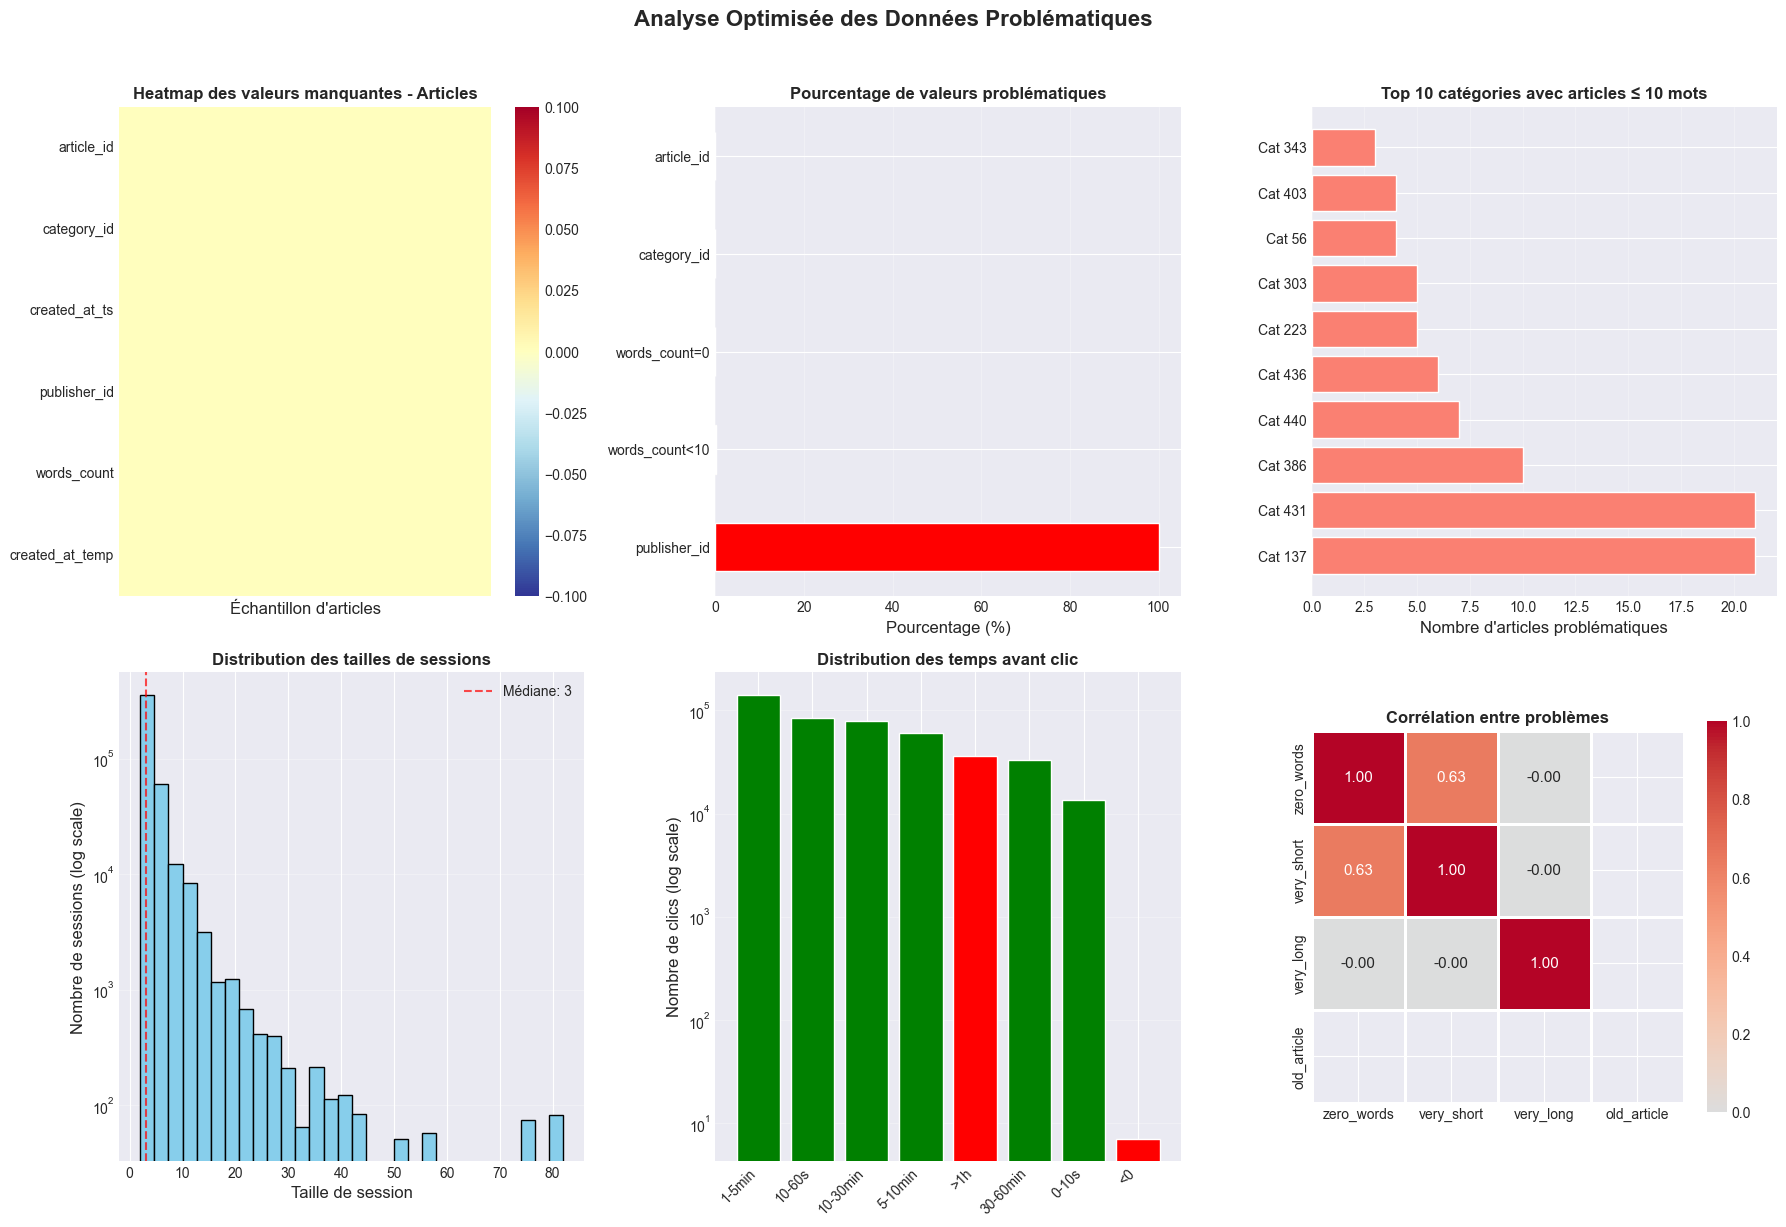


📊 SYNTHÈSE DES PROBLÈMES IDENTIFIÉS

🔴 Problèmes critiques:
  • Articles avec 0 mots: 35 (0.01%)
  • Articles < 10 mots: 87 (0.02%)
  • Temps de clic négatifs: 0
  • Sessions > 100 articles: 0

🟡 Catégories les plus problématiques:
  • Catégorie 137: 21 articles problématiques
  • Catégorie 431: 21 articles problématiques
  • Catégorie 386: 10 articles problématiques

✅ Points positifs:
  • Aucune valeur manquante dans les métadonnées
  • 100.0% des articles ont un contenu valide
  • Médiane des tailles de session: 3 (raisonnable)


In [10]:
# Visualisations OPTIMISÉES des données manquantes et problématiques
print("\nVISUALISATIONS GRAPHIQUES")

# S'assurer que time_to_click existe
if 'time_to_click' not in clicks_df.columns:
    clicks_df['time_to_click'] = (clicks_df['click_timestamp'] - clicks_df['session_start']) / 1000

# Créer une figure avec seulement les graphiques pertinents (2x3 au lieu de 3x3)
fig = plt.figure(figsize=(18, 12))

# 1. Heatmap des valeurs manquantes - Articles (PERTINENT)
ax1 = plt.subplot(2, 3, 1)
missing_matrix = articles_raw.isnull().astype(int)
sns.heatmap(missing_matrix.T, cbar=True, cmap='RdYlBu_r',
            yticklabels=articles_raw.columns, xticklabels=False, ax=ax1)
ax1.set_title('Heatmap des valeurs manquantes - Articles', fontsize=12, fontweight='bold')
ax1.set_xlabel('Échantillon d\'articles')

# 2. Pourcentage de valeurs problématiques par colonne (PERTINENT - modifié)
ax2 = plt.subplot(2, 3, 2)
# Analyse des valeurs problématiques au lieu des valeurs manquantes
problem_data = pd.Series({
    'words_count=0': (articles_raw['words_count'] == 0).sum(),
    'words_count<10': (articles_raw['words_count'] < 10).sum(),
    'publisher_id': (articles_raw['publisher_id'] == 0).sum(),
    'category_id': (articles_raw['category_id'] == 0).sum(),
    'article_id': (articles_raw['article_id'] == 0).sum()
})
problem_pct = (problem_data / len(articles_raw) * 100).sort_values(ascending=False)
colors = ['red' if x > 0.05 else 'orange' if x > 0.01 else 'green' for x in problem_pct.values]
problem_pct.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Pourcentage de valeurs problématiques', fontsize=12, fontweight='bold')
ax2.set_xlabel('Pourcentage (%)')
ax2.grid(axis='x', alpha=0.3)

# 3. Top catégories avec articles problématiques (PERTINENT)
ax3 = plt.subplot(2, 3, 3)
problem_categories = articles_raw[articles_raw['words_count'] <= 10].groupby('category_id').size().nlargest(10)
ax3.barh(range(len(problem_categories)), problem_categories.values, color='salmon')
ax3.set_yticks(range(len(problem_categories)))
ax3.set_yticklabels([f'Cat {int(cat)}' for cat in problem_categories.index])
ax3.set_title('Top 10 catégories avec articles ≤ 10 mots', fontsize=12, fontweight='bold')
ax3.set_xlabel('Nombre d\'articles problématiques')
ax3.grid(axis='x', alpha=0.3)

# 4. Distribution des tailles de sessions (PERTINENT)
ax4 = plt.subplot(2, 3, 4)
session_sizes = clicks_df['session_size'].value_counts().sort_index()
if len(session_sizes) > 0:
    ax4.hist(clicks_df['session_size'], bins=30, color='skyblue', edgecolor='black')
    ax4.set_title('Distribution des tailles de sessions', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Nombre de sessions (log scale)')
    ax4.set_xlabel('Taille de session')
    ax4.set_yscale('log')
    ax4.grid(axis='y', alpha=0.3)
    # Ajouter une ligne verticale pour la médiane
    median_size = clicks_df['session_size'].median()
    ax4.axvline(x=median_size, color='red', linestyle='--', alpha=0.7, label=f'Médiane: {median_size:.0f}')
    ax4.legend()

# 5. Distribution des temps avant clic (PERTINENT - focus sur les anomalies)
ax5 = plt.subplot(2, 3, 5)
if 'time_to_click' in clicks_df.columns:
    time_bins = [-np.inf, 0, 10, 60, 300, 600, 1800, 3600, np.inf]
    time_labels = ['<0', '0-10s', '10-60s', '1-5min', '5-10min', '10-30min', '30-60min', '>1h']
    time_dist = pd.cut(clicks_df['time_to_click'], bins=time_bins, labels=time_labels).value_counts()
    
    time_dist = time_dist[time_dist > 0]
    
    if len(time_dist) > 0:
        colors_time = ['red' if label in ['<0', '>1h'] else 'green' for label in time_dist.index]
        ax5.bar(range(len(time_dist)), time_dist.values, color=colors_time)
        ax5.set_xticks(range(len(time_dist)))
        ax5.set_xticklabels(time_dist.index, rotation=45, ha='right')
        ax5.set_ylabel('Nombre de clics (log scale)')
        ax5.set_yscale('log')
ax5.set_title('Distribution des temps avant clic', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Corrélation entre problèmes (PERTINENT)
ax6 = plt.subplot(2, 3, 6)
problems_df = pd.DataFrame({
    'zero_words': articles_raw['words_count'] == 0,
    'very_short': articles_raw['words_count'] < 10,
    'very_long': articles_raw['words_count'] > 2000,
    'old_article': (pd.Timestamp.now() - pd.to_datetime(articles_raw['created_at_ts'], unit='ms')).dt.days > 1825
})
corr_matrix = problems_df.astype(int).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax6,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax6.set_title('Corrélation entre problèmes', fontsize=12, fontweight='bold')

plt.suptitle('Analyse Optimisée des Données Problématiques',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Rapport synthétique des problèmes identifiés
print("\n📊 SYNTHÈSE DES PROBLÈMES IDENTIFIÉS")
print("="*60)

print("\n🔴 Problèmes critiques:")
print(f"  • Articles avec 0 mots: {(articles_raw['words_count'] == 0).sum()} ({(articles_raw['words_count'] == 0).sum()/len(articles_raw)*100:.2f}%)")
print(f"  • Articles < 10 mots: {(articles_raw['words_count'] < 10).sum()} ({(articles_raw['words_count'] < 10).sum()/len(articles_raw)*100:.2f}%)")
print(f"  • Temps de clic négatifs: {(clicks_df['time_to_click'] < 0).sum() if 'time_to_click' in clicks_df.columns else 0}")
print(f"  • Sessions > 100 articles: {(clicks_df['session_size'] > 100).sum()}")

print("\n🟡 Catégories les plus problématiques:")
top_3_problematic = problem_categories.head(3)
for cat_id, count in top_3_problematic.items():
    print(f"  • Catégorie {cat_id}: {count} articles problématiques")

print("\n✅ Points positifs:")
print(f"  • Aucune valeur manquante dans les métadonnées")
print(f"  • {100 - (articles_raw['words_count'] < 10).sum()/len(articles_raw)*100:.1f}% des articles ont un contenu valide")
print(f"  • Médiane des tailles de session: {clicks_df['session_size'].median():.0f} (raisonnable)")

## 3. Exploration approfondie des métadonnées d'articles

In [11]:
# Analyse détaillée des catégories
# Statistiques des catégories
category_stats = articles_df.groupby('category_id').agg({
    'article_id': 'count',
    'words_count': ['mean', 'std', 'min', 'max'],
    'created_at': ['min', 'max']
}).round(2)

category_stats.columns = ['nb_articles', 'mots_moy', 'mots_std', 'mots_min', 'mots_max', 'date_debut', 'date_fin']
category_stats = category_stats.sort_values('nb_articles', ascending=False)

# Calculer la durée de vie de chaque catégorie
category_stats['duree_jours'] = (category_stats['date_fin'] - category_stats['date_debut']).dt.days

# Identifier les catégories "mortes" vs "actives"
cutoff_date = articles_df['created_at'].max() - pd.Timedelta(days=180)
active_categories = category_stats[category_stats['date_fin'] > cutoff_date]
inactive_categories = category_stats[category_stats['date_fin'] <= cutoff_date]

# Top 10 catégories
category_stats.head(10)

,nb_articles,mots_moy,mots_std,mots_min,mots_max,date_debut,date_fin,duree_jours
category_id,,,,,,,,
281,12817,225.17,65.31,14,1757,2011-12-01 10:39:07,2018-02-28 21:04:59,2281
375,10005,190.13,48.81,0,1608,2010-04-16 20:22:17,2017-11-16 13:57:04,2770
399,9049,188.22,43.34,18,1409,2013-04-19 16:36:19,2018-02-28 23:23:03,1776
412,8648,191.47,51.43,9,1553,2011-04-01 12:20:15,2017-11-16 14:11:37,2421
431,7759,192.39,49.19,0,1119,2012-07-03 10:44:22,2018-02-28 21:19:07,2066
428,7731,178.87,46.44,18,1529,2012-08-21 18:23:19,2018-02-28 22:58:58,2017
26,7343,198.00,47.85,20,1148,2012-07-23 19:42:17,2017-11-16 14:35:12,1941
7,6726,195.75,53.41,10,1676,2011-12-01 11:27:53,2018-02-28 23:09:02,2281
299,6634,190.63,56.14,9,1495,2013-02-19 09:32:31,2018-02-28 21:25:11,1835


In [12]:
# Création de labels intelligents pour les catégories
def create_category_labels(category_stats, articles_df):
    """Crée des labels descriptifs pour les catégories basés sur leurs caractéristiques"""

    labels = {}

    for cat_id in category_stats.index:
        cat_data = category_stats.loc[cat_id]

        # Déterminer le type de contenu basé sur la longueur moyenne
        if cat_data['mots_moy'] < 150:
            content_type = "Short"
        elif cat_data['mots_moy'] < 250:
            content_type = "Medium"
        else:
            content_type = "Long"

        # Déterminer la popularité
        if cat_data['nb_articles'] > category_stats['nb_articles'].quantile(0.75):
            popularity = "Popular"
        elif cat_data['nb_articles'] > category_stats['nb_articles'].quantile(0.25):
            popularity = "Standard"
        else:
            popularity = "Niche"

        # Déterminer l'âge
        if cat_data['date_fin'] > articles_df['created_at'].max() - pd.Timedelta(days=90):
            age = "Recent"
        elif cat_data['date_fin'] > articles_df['created_at'].max() - pd.Timedelta(days=365):
            age = "Active"
        else:
            age = "Archive"

        # Créer le label
        labels[cat_id] = f"Cat_{cat_id}_{content_type}_{popularity}_{age}"

    return labels

# Créer les labels
category_labels = create_category_labels(category_stats, articles_df)

# Ajouter les labels au DataFrame
articles_df['category_label'] = articles_df['category_id'].map(category_labels)

# Statistiques sur les types de labels
label_parts = pd.DataFrame([label.split('_')[2:] for label in category_labels.values()],
                           columns=['content_type', 'popularity', 'age'])

# Distribution des caractéristiques
label_distribution = {}
for col in label_parts.columns:
    label_distribution[col] = label_parts[col].value_counts().to_dict()


ANALYSE DES PATTERNS TEMPORELS


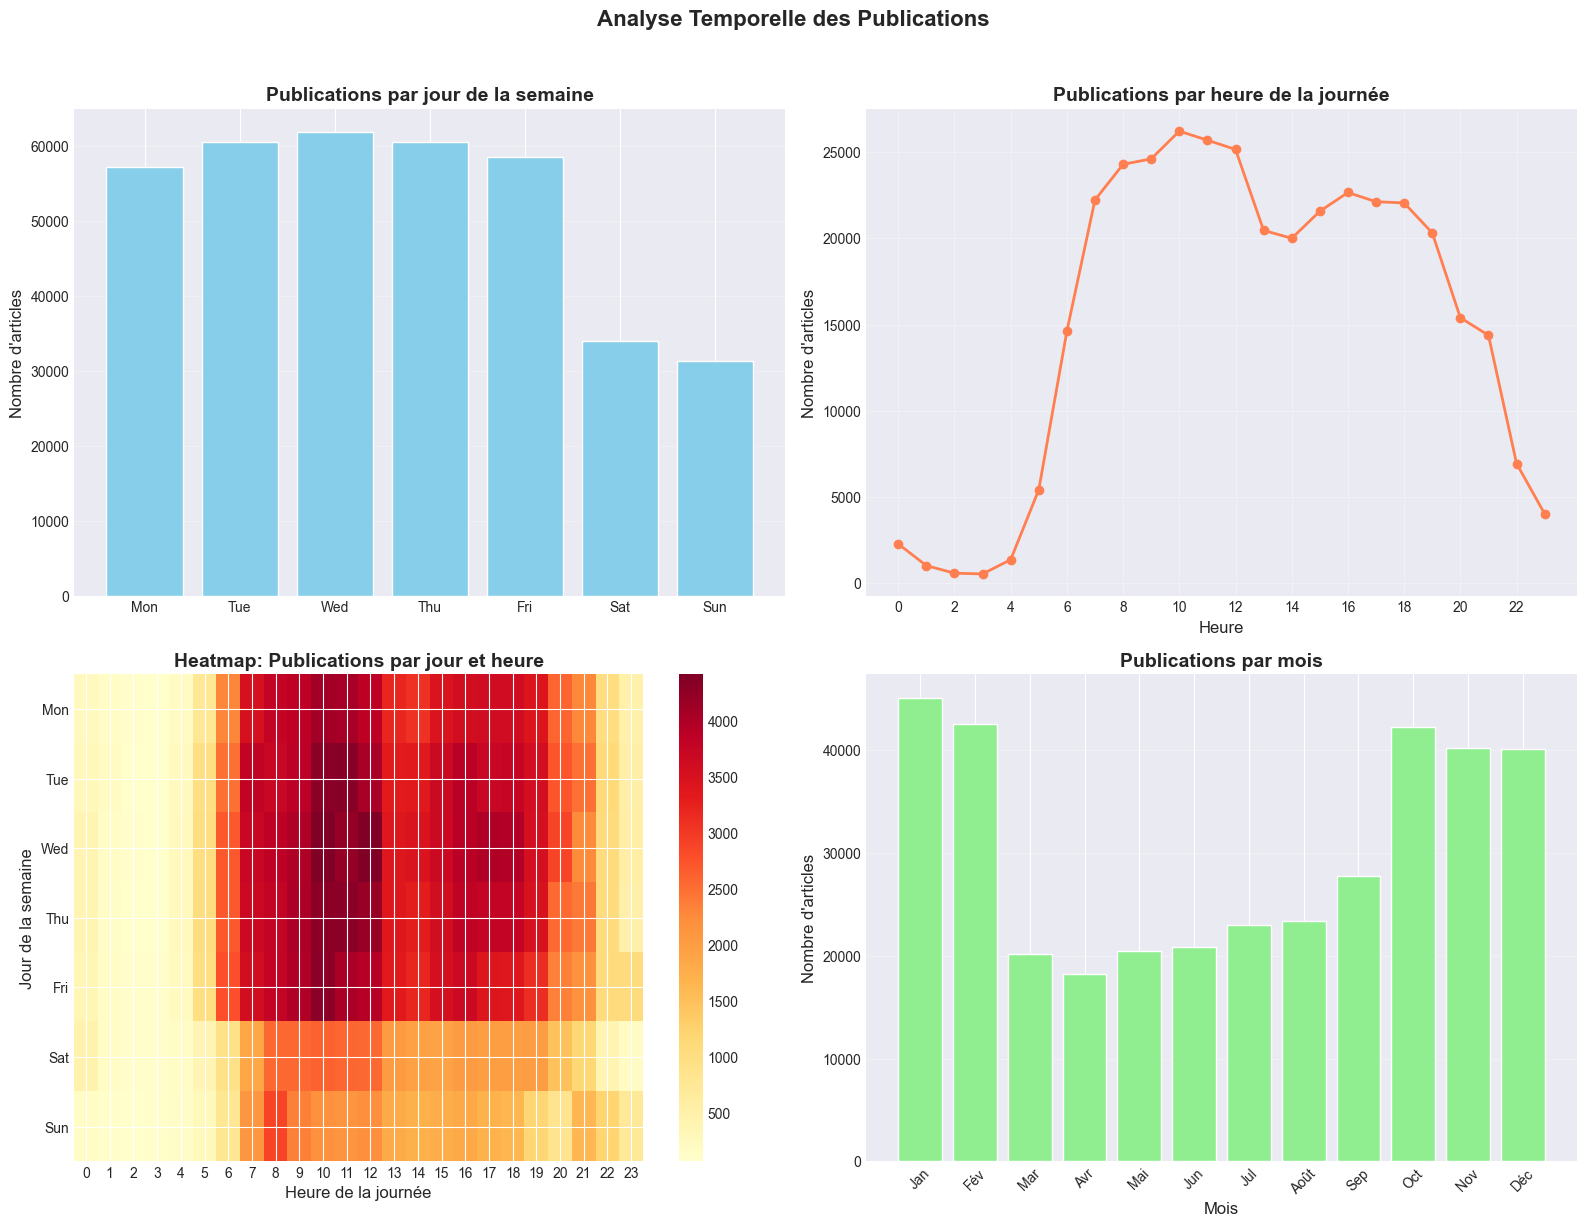


Jour le plus actif: Wednesday (61,842 articles)
Heure de pointe: 10h (26,215 articles)


In [13]:
# Patterns temporels dans la publication d'articles
print("\nANALYSE DES PATTERNS TEMPORELS")
print("="*60)

# Analyse par jour de la semaine
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
articles_by_day = articles_df['day_of_week'].value_counts().reindex(day_order)

# Analyse par heure
articles_by_hour = articles_df['hour'].value_counts().sort_index()

# Analyse par mois
articles_by_month = articles_df['month'].value_counts().sort_index()

# Créer un heatmap temporel
temporal_matrix = articles_df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
temporal_matrix = temporal_matrix.reindex(day_order)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Articles par jour de la semaine
axes[0, 0].bar(range(len(articles_by_day)), articles_by_day.values, color='skyblue')
axes[0, 0].set_xticks(range(len(articles_by_day)))
axes[0, 0].set_xticklabels([day[:3] for day in day_order], rotation=0)
axes[0, 0].set_title('Publications par jour de la semaine', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Nombre d\'articles')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Articles par heure
axes[0, 1].plot(articles_by_hour.index, articles_by_hour.values, 'o-', color='coral', linewidth=2)
axes[0, 1].set_title('Publications par heure de la journée', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Heure')
axes[0, 1].set_ylabel('Nombre d\'articles')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# 3. Heatmap jour/heure
im = axes[1, 0].imshow(temporal_matrix, aspect='auto', cmap='YlOrRd')
axes[1, 0].set_title('Heatmap: Publications par jour et heure', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Heure de la journée')
axes[1, 0].set_ylabel('Jour de la semaine')
axes[1, 0].set_xticks(range(24))
axes[1, 0].set_xticklabels(range(24))
axes[1, 0].set_yticks(range(len(day_order)))
axes[1, 0].set_yticklabels([day[:3] for day in day_order])
plt.colorbar(im, ax=axes[1, 0])

# 4. Tendance mensuelle
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun',
               'Jul', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
axes[1, 1].bar(range(1, 13), articles_by_month.values, color='lightgreen')
axes[1, 1].set_title('Publications par mois', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Mois')
axes[1, 1].set_ylabel('Nombre d\'articles')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_names, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Analyse Temporelle des Publications', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nJour le plus actif: {articles_by_day.idxmax()} ({articles_by_day.max():,} articles)")
print(f"Heure de pointe: {articles_by_hour.idxmax()}h ({articles_by_hour.max():,} articles)")

## 4. Analyse temporelle approfondie

In [14]:
# Analyse approfondie des comportements utilisateurs
print("\nANALYSE DES COMPORTEMENTS UTILISATEURS")
print("="*60)

# Créer des profils utilisateurs enrichis
user_profiles = clicks_df.groupby('user_id').agg({
    'click_article_id': ['count', 'nunique'],
    'session_id': 'nunique',
    'session_size': 'mean',
    'click_timestamp_dt': ['min', 'max'],
    'click_environment': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'click_deviceGroup': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'click_country': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
})

user_profiles.columns = ['total_clicks', 'unique_articles', 'sessions', 'avg_session_size',
                         'first_click', 'last_click', 'main_environment',
                         'main_device', 'country']

# Calculer des métriques dérivées
user_profiles['days_active'] = (user_profiles['last_click'] - user_profiles['first_click']).dt.days + 1
user_profiles['clicks_per_day'] = user_profiles['total_clicks'] / user_profiles['days_active']
user_profiles['article_diversity'] = user_profiles['unique_articles'] / user_profiles['total_clicks']
user_profiles['sessions_per_day'] = user_profiles['sessions'] / user_profiles['days_active']

print(f"\nNombre total d'utilisateurs: {len(user_profiles):,}")
print(f"Clics moyens par utilisateur: {user_profiles['total_clicks'].mean():.2f}")
print(f"Articles uniques moyens: {user_profiles['unique_articles'].mean():.2f}")
print(f"Diversité moyenne: {user_profiles['article_diversity'].mean():.3f}")

# Segmentation des utilisateurs
def segment_users(user_profiles):
    """Segmente les utilisateurs en différents groupes comportementaux"""
    segments = []

    for idx, user in user_profiles.iterrows():
        if user['total_clicks'] >= user_profiles['total_clicks'].quantile(0.75):
            if user['article_diversity'] >= 0.7:
                segment = 'Explorer_Actif'
            else:
                segment = 'Lecteur_Fidèle'
        elif user['total_clicks'] >= user_profiles['total_clicks'].quantile(0.25):
            if user['article_diversity'] >= 0.7:
                segment = 'Explorer_Modéré'
            else:
                segment = 'Lecteur_Régulier'
        else:
            if user['sessions'] == 1:
                segment = 'Visiteur_Unique'
            else:
                segment = 'Lecteur_Occasionnel'

        segments.append(segment)

    return segments

user_profiles['segment'] = segment_users(user_profiles)

# Afficher la distribution des segments
print("\nSegmentation des utilisateurs:")
segment_dist = user_profiles['segment'].value_counts()
for segment, count in segment_dist.items():
    print(f"  {segment}: {count} ({count/len(user_profiles)*100:.1f}%)")

# Top utilisateurs
print("\nTop 5 utilisateurs les plus actifs:")
top_users = user_profiles.nlargest(5, 'total_clicks')
display(top_users[['total_clicks', 'unique_articles', 'article_diversity', 'segment']])


ANALYSE DES COMPORTEMENTS UTILISATEURS

Nombre total d'utilisateurs: 117,185
Clics moyens par utilisateur: 3.83
Articles uniques moyens: 3.77
Diversité moyenne: 0.993

Segmentation des utilisateurs:
  Explorer_Modéré: 74555 (63.6%)
  Explorer_Actif: 42408 (36.2%)
  Lecteur_Fidèle: 222 (0.2%)

Top 5 utilisateurs les plus actifs:


,total_clicks,unique_articles,article_diversity,segment
user_id,,,,
5890,182,153,0.840659,Explorer_Actif
73574,157,157,1.000000,Explorer_Actif
15275,151,146,0.966887,Explorer_Actif
2151,101,78,0.772277,Explorer_Actif
15867,96,71,0.739583,Explorer_Actif


In [15]:
# Analyse approfondie des comportements utilisateurs
print("\n👥 ANALYSE DES COMPORTEMENTS UTILISATEURS")
print("="*60)

# Créer des profils utilisateurs enrichis
user_profiles = clicks_df.groupby('user_id').agg({
    'click_article_id': ['count', 'nunique'],
    'session_id': 'nunique',
    'session_size': 'mean',
    'click_timestamp_dt': ['min', 'max'],
    'click_environment': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'click_deviceGroup': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'click_country': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
})

user_profiles.columns = ['total_clicks', 'unique_articles', 'sessions', 'avg_session_size',
                         'first_click', 'last_click', 'main_environment',
                         'main_device', 'country']

# Calculer des métriques dérivées
user_profiles['days_active'] = (user_profiles['last_click'] - user_profiles['first_click']).dt.days + 1
user_profiles['clicks_per_day'] = user_profiles['total_clicks'] / user_profiles['days_active']
user_profiles['article_diversity'] = user_profiles['unique_articles'] / user_profiles['total_clicks']
user_profiles['sessions_per_day'] = user_profiles['sessions'] / user_profiles['days_active']

print("\n📊 Statistiques générales des utilisateurs:")
print(f"  • Nombre total d'utilisateurs: {len(user_profiles):,}")
print(f"  • Clics moyens par utilisateur: {user_profiles['total_clicks'].mean():.2f}")
print(f"  • Articles uniques moyens: {user_profiles['unique_articles'].mean():.2f}")
print(f"  • Diversité moyenne: {user_profiles['article_diversity'].mean():.3f}")

# Segmentation des utilisateurs
def segment_users(user_profiles):
    """Segmente les utilisateurs en différents groupes comportementaux"""
    segments = []

    for idx, user in user_profiles.iterrows():
        if user['total_clicks'] >= user_profiles['total_clicks'].quantile(0.75):
            if user['article_diversity'] >= 0.7:
                segment = 'Explorer_Actif'
            else:
                segment = 'Lecteur_Fidèle'
        elif user['total_clicks'] >= user_profiles['total_clicks'].quantile(0.25):
            if user['article_diversity'] >= 0.7:
                segment = 'Explorer_Modéré'
            else:
                segment = 'Lecteur_Régulier'
        else:
            if user['sessions'] == 1:
                segment = 'Visiteur_Unique'
            else:
                segment = 'Lecteur_Occasionnel'

        segments.append(segment)

    return segments

user_profiles['segment'] = segment_users(user_profiles)

# Afficher la distribution des segments
print("\n🎯 Segmentation des utilisateurs:")
segment_dist = user_profiles['segment'].value_counts()
for segment, count in segment_dist.items():
    print(f"  • {segment}: {count} ({count/len(user_profiles)*100:.1f}%)")

# Top utilisateurs
print("\n🏆 Top 5 utilisateurs les plus actifs:")
top_users = user_profiles.nlargest(5, 'total_clicks')
display(top_users[['total_clicks', 'unique_articles', 'article_diversity', 'segment']])


👥 ANALYSE DES COMPORTEMENTS UTILISATEURS

📊 Statistiques générales des utilisateurs:
  • Nombre total d'utilisateurs: 117,185
  • Clics moyens par utilisateur: 3.83
  • Articles uniques moyens: 3.77
  • Diversité moyenne: 0.993

🎯 Segmentation des utilisateurs:
  • Explorer_Modéré: 74555 (63.6%)
  • Explorer_Actif: 42408 (36.2%)
  • Lecteur_Fidèle: 222 (0.2%)

🏆 Top 5 utilisateurs les plus actifs:


,total_clicks,unique_articles,article_diversity,segment
user_id,,,,
5890,182,153,0.840659,Explorer_Actif
73574,157,157,1.000000,Explorer_Actif
15275,151,146,0.966887,Explorer_Actif
2151,101,78,0.772277,Explorer_Actif
15867,96,71,0.739583,Explorer_Actif


In [16]:
# Analyse des embeddings avec réduction de dimension
print("\nANALYSE DES EMBEDDINGS D'ARTICLES")
print("="*60)

# Échantillonner pour la visualisation
sample_size = 5000
sample_indices = np.random.choice(len(embeddings_array), sample_size, replace=False)
sample_embeddings = embeddings_array[sample_indices]
sample_articles = articles_df.iloc[sample_indices]

print(f"Échantillon de {sample_size} articles pour l'analyse...")

# PCA pour réduction de dimension
print("\nRéduction de dimension avec PCA...")
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(sample_embeddings)

print(f"  Variance expliquée par les 10 premiers composants: {pca.explained_variance_ratio_[:10].sum():.2%}")
print(f"  Variance expliquée par les 50 composants: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE pour visualisation 2D
print("\nProjection t-SNE pour visualisation...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Clustering pour identifier des groupes d'articles
print("\nClustering des articles...")
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_pca)

sample_articles['cluster'] = clusters
sample_articles['tsne_x'] = embeddings_2d[:, 0]
sample_articles['tsne_y'] = embeddings_2d[:, 1]

print(f"  Nombre de clusters: {n_clusters}")
print("  Distribution des clusters:")
cluster_dist = pd.Series(clusters).value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    print(f"    - Cluster {cluster_id}: {count} articles ({count/len(clusters)*100:.1f}%)")


ANALYSE DES EMBEDDINGS D'ARTICLES
Échantillon de 5000 articles pour l'analyse...

Réduction de dimension avec PCA...
  Variance expliquée par les 10 premiers composants: 49.84%
  Variance expliquée par les 50 composants: 94.61%

Projection t-SNE pour visualisation...

Clustering des articles...
  Nombre de clusters: 10
  Distribution des clusters:
    - Cluster 0: 345 articles (6.9%)
    - Cluster 1: 589 articles (11.8%)
    - Cluster 2: 583 articles (11.7%)
    - Cluster 3: 533 articles (10.7%)
    - Cluster 4: 288 articles (5.8%)
    - Cluster 5: 519 articles (10.4%)
    - Cluster 6: 849 articles (17.0%)
    - Cluster 7: 499 articles (10.0%)
    - Cluster 8: 511 articles (10.2%)
    - Cluster 9: 284 articles (5.7%)


## 6. Exploration avancée des embeddings

In [17]:
# Visualisation interactive des embeddings
print("\n📊 VISUALISATION INTERACTIVE DES EMBEDDINGS")
print("="*60)

# Créer une visualisation Plotly interactive
fig = px.scatter(
    sample_articles,
    x='tsne_x',
    y='tsne_y',
    color='cluster',
    hover_data=['article_id', 'category_id', 'words_count'],
    title='Projection t-SNE des Embeddings d\'Articles',
    labels={'tsne_x': 'Dimension 1', 'tsne_y': 'Dimension 2'},
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(
    width=900,
    height=600,
    hovermode='closest'
)

fig.show()

# Analyser les caractéristiques de chaque cluster
print("\n🔍 Analyse des caractéristiques des clusters:")
cluster_analysis = sample_articles.groupby('cluster').agg({
    'category_id': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'words_count': ['mean', 'std'],
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'article_id': 'count'
}).round(2)

cluster_analysis.columns = ['dominant_category', 'avg_words', 'std_words', 'dominant_year', 'n_articles']

print("\nCaractéristiques de chaque cluster:")
display(cluster_analysis)

# Identifier les articles centraux de chaque cluster
print("\n🎯 Articles représentatifs de chaque cluster:")
for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_center = kmeans.cluster_centers_[cluster_id]

    # Trouver l'article le plus proche du centre
    distances = np.linalg.norm(embeddings_pca[cluster_mask] - cluster_center, axis=1)
    closest_idx = np.argmin(distances)

    # Obtenir l'article correspondant
    representative_article = sample_articles[sample_articles['cluster'] == cluster_id].iloc[closest_idx]

    print(f"\n  Cluster {cluster_id}:")
    print(f"    • Article ID: {representative_article['article_id']}")
    print(f"    • Catégorie: {representative_article['category_id']}")
    print(f"    • Nombre de mots: {representative_article['words_count']}")
    print(f"    • Date: {representative_article['created_at'].strftime('%Y-%m-%d')}")


📊 VISUALISATION INTERACTIVE DES EMBEDDINGS



🔍 Analyse des caractéristiques des clusters:

Caractéristiques de chaque cluster:


,dominant_category,avg_words,std_words,dominant_year,n_articles
cluster,,,,,
0,375,190.27,80.20,2017,345
1,228,157.87,57.34,2017,589
2,7,201.24,65.92,2017,583
3,281,212.66,49.11,2015,533
4,412,190.58,50.12,2017,288
5,26,192.87,56.81,2017,519
6,428,182.67,37.44,2017,849
7,431,190.45,43.48,2017,499
8,281,208.23,46.14,2017,511



🎯 Articles représentatifs de chaque cluster:

  Cluster 0:
    • Article ID: 237345
    • Catégorie: 375
    • Nombre de mots: 177
    • Date: 2017-07-19

  Cluster 1:
    • Article ID: 226800
    • Catégorie: 368
    • Nombre de mots: 113
    • Date: 2018-02-27

  Cluster 2:
    • Article ID: 16109
    • Catégorie: 7
    • Nombre de mots: 217
    • Date: 2017-11-09

  Cluster 3:
    • Article ID: 112325
    • Catégorie: 237
    • Nombre de mots: 193
    • Date: 2014-07-13

  Cluster 4:
    • Article ID: 345151
    • Catégorie: 440
    • Nombre de mots: 235
    • Date: 2018-02-06

  Cluster 5:
    • Article ID: 30087
    • Catégorie: 26
    • Nombre de mots: 188
    • Date: 2017-09-04

  Cluster 6:
    • Article ID: 7194
    • Catégorie: 6
    • Nombre de mots: 190
    • Date: 2016-09-21

  Cluster 7:
    • Article ID: 286850
    • Catégorie: 418
    • Nombre de mots: 101
    • Date: 2013-10-24

  Cluster 8:
    • Article ID: 281034
    • Catégorie: 412
    • Nombre de mots: 178
    •

In [18]:
# Création de labels descriptifs pour les articles populaires
print("\n🏷️ CRÉATION DE LABELS POUR LES ARTICLES")
print("="*60)

# Identifier les articles les plus populaires
article_popularity = clicks_df['click_article_id'].value_counts()
top_articles = article_popularity.head(100).index

# Créer des labels pour ces articles
def create_article_label(article_id, articles_df, clicks_df):
    """Crée un label descriptif pour un article"""

    # Obtenir les métadonnées de l'article
    article_data = articles_df[articles_df['article_id'] == article_id]

    if len(article_data) == 0:
        return f"Article_{article_id}_Unknown"

    article_data = article_data.iloc[0]

    # Obtenir les statistiques de clics
    click_count = (clicks_df['click_article_id'] == article_id).sum()

    # Déterminer les caractéristiques
    # Longueur
    if article_data['words_count'] < 150:
        length = "Short"
    elif article_data['words_count'] < 250:
        length = "Medium"
    else:
        length = "Long"

    # Popularité
    if click_count > article_popularity.quantile(0.9):
        popularity = "VeryPopular"
    elif click_count > article_popularity.quantile(0.5):
        popularity = "Popular"
    else:
        popularity = "Standard"

    # Âge
    age_days = (articles_df['created_at'].max() - article_data['created_at']).days
    if age_days < 30:
        age = "New"
    elif age_days < 365:
        age = "Recent"
    else:
        age = "Old"

    # Créer le label
    return f"Art_{article_id:.0f}_Cat{article_data['category_id']:.0f}_{length}_{popularity}_{age}"

# Créer les labels pour les top articles
article_labels = {}
for article_id in top_articles:
    article_labels[article_id] = create_article_label(article_id, articles_df, clicks_df)

print(f"Labels créés pour {len(article_labels)} articles populaires")

# Afficher quelques exemples
print("\n📋 Exemples de labels d'articles:")
for i, (article_id, label) in enumerate(list(article_labels.items())[:10]):
    click_count = article_popularity[article_id]
    print(f"  • Article {article_id:.0f} ({click_count} clics): {label}")

# Créer un DataFrame enrichi pour les articles populaires
popular_articles_df = pd.DataFrame({
    'article_id': list(article_labels.keys()),
    'label': list(article_labels.values()),
    'click_count': [article_popularity[aid] for aid in article_labels.keys()]
})

# Enrichir avec les métadonnées
popular_articles_df = popular_articles_df.merge(
    articles_df[['article_id', 'category_id', 'words_count', 'created_at']],
    on='article_id',
    how='left'
)

print("\n📊 Distribution des caractéristiques des articles populaires:")
# Extraire les caractéristiques des labels
popular_articles_df['length_type'] = popular_articles_df['label'].str.extract(r'_(Short|Medium|Long)_')[0]
popular_articles_df['popularity_type'] = popular_articles_df['label'].str.extract(r'_(VeryPopular|Popular|Standard)_')[0]
popular_articles_df['age_type'] = popular_articles_df['label'].str.extract(r'_(New|Recent|Old)$')[0]

for col in ['length_type', 'popularity_type', 'age_type']:
    print(f"\n{col.replace('_', ' ').title()}:")
    for value, count in popular_articles_df[col].value_counts().items():
        print(f"  • {value}: {count} ({count/len(popular_articles_df)*100:.1f}%)")


🏷️ CRÉATION DE LABELS POUR LES ARTICLES
Labels créés pour 100 articles populaires

📋 Exemples de labels d'articles:
  • Article 160974 (36336 clics): Art_160974_Cat281_Long_VeryPopular_Recent
  • Article 162655 (18705 clics): Art_162655_Cat281_Medium_VeryPopular_Recent
  • Article 158536 (16766 clics): Art_158536_Cat281_Long_VeryPopular_Recent
  • Article 272660 (16135 clics): Art_272660_Cat399_Medium_VeryPopular_Recent
  • Article 272143 (15039 clics): Art_272143_Cat399_Medium_VeryPopular_Recent
  • Article 199198 (13425 clics): Art_199198_Cat323_Medium_VeryPopular_Recent
  • Article 64329 (11703 clics): Art_64329_Cat134_Medium_VeryPopular_Recent
  • Article 160417 (10596 clics): Art_160417_Cat281_Medium_VeryPopular_Recent
  • Article 166581 (10295 clics): Art_166581_Cat289_Medium_VeryPopular_Recent
  • Article 59758 (9760 clics): Art_59758_Cat123_Medium_VeryPopular_Recent

📊 Distribution des caractéristiques des articles populaires:

Length Type:
  • Medium: 83 (83.0%)
  • Long: 12 

In [19]:
# Synthèse des insights clés
# Calculer des métriques clés
total_interactions = len(clicks_df)
unique_users = clicks_df['user_id'].nunique()
unique_articles_clicked = clicks_df['click_article_id'].nunique()
coverage_rate = unique_articles_clicked / len(articles_df) * 100

# Analyser la concentration
top_10_percent_articles = int(len(article_popularity) * 0.1)
top_10_percent_clicks = article_popularity.head(top_10_percent_articles).sum()
concentration_rate = top_10_percent_clicks / total_interactions * 100

# Problème de Cold Start
cold_articles = len(articles_df) - unique_articles_clicked

# Patterns temporels
peak_hour = clicks_df['hour_of_day'].mode()[0]
peak_day = clicks_df['day_of_week'].mode()[0]

# Qualité du contenu
avg_words = articles_df['words_count'].mean()
median_words = articles_df['words_count'].median()

# Créer un DataFrame de synthèse avec toutes les métriques importantes
summary_metrics = pd.DataFrame({
    'Métrique': [
        'Interactions totales',
        'Utilisateurs uniques',
        'Articles dans le catalogue',
        'Articles avec au moins un clic',
        'Taux de couverture (%)',
        'Concentration 10% (%)',
        'Articles jamais cliqués',
        'Heure de pointe',
        'Jour le plus actif',
        'Longueur moyenne (mots)',
        'Longueur médiane (mots)',
        'Dimension embeddings',
        'Clusters identifiés',
        'Segments utilisateurs'
    ],
    'Valeur': [
        total_interactions,
        unique_users,
        len(articles_df),
        unique_articles_clicked,
        f"{coverage_rate:.2f}",
        f"{concentration_rate:.1f}",
        cold_articles,
        f"{peak_hour}h",
        peak_day,
        f"{avg_words:.0f}",
        f"{median_words:.0f}",
        embeddings_array.shape[1],
        n_clusters,
        len(user_profiles['segment'].unique())
    ]
})

# Dataframes principaux disponibles pour analyse
dataframes_disponibles = {
    'articles_df': articles_df,  # Articles avec labels de catégories
    'clicks_df': clicks_df,  # Interactions utilisateurs
    'user_profiles': user_profiles,  # Profils et segments utilisateurs
    'category_stats': category_stats,  # Statistiques des catégories
    'popular_articles_df': popular_articles_df,  # Top articles avec labels
    'summary_metrics': summary_metrics  # Métriques de synthèse
}

# Afficher le résumé
summary_metrics

,Métrique,Valeur
0,Interactions totales,448380
1,Utilisateurs uniques,117185
2,Articles dans le catalogue,364047
3,Articles avec au moins un clic,9386
4,Taux de couverture (%),2.58
5,Concentration 10% (%),95.9
6,Articles jamais cliqués,354661
7,Heure de pointe,22h
8,Jour le plus actif,Monday
9,Longueur moyenne (mots),191
